<a href="https://colab.research.google.com/github/lorenzodegregorio/federated_learning_project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
import sys
proj_dir = '/content/drive/MyDrive/fed_learning'
sys.path.insert(0, proj_dir)
os.chdir(proj_dir)

Mounted at /content/drive


In [ ]:
# Stage 1 – Centralized Training

from data_utils import load_cifar100, split_data_iid, split_data_noniid
from centralized_baseline import train_centralized_model, get_dataloaders
from sparse_utils import compute_sensitivity, calibrate_gradient_mask, SparseSGD
from fl_model_utils import evaluate_model, federated_aggregation
from modelsaver import ModelSaver
from dino_vits16 import load_dino_vits16, DINOClassifier
from secure_aggregation import secure_aggregate


import torch
torch.cuda.is_available()


True

In [ ]:
import torch
import random
from copy import deepcopy
import re
import gc
import urllib.request
import matplotlib.pyplot as plt
import glob


from copy import deepcopy
from tqdm import tqdm
from torch import nn
from torch.utils.data import DataLoader
from torchvision.models import vit_b_16
from torchvision import transforms
from torch.utils.data import Subset


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
gc.collect()
torch.cuda.empty_cache()

# Load CIFAR-100
train_ds, val_ds, test_ds = load_cifar100(validation_split=0.1)


In [ ]:
# STAGE 1
# Centralized Training of DINO on CIFAR-100

# Step 2: Load datasets (with val split)
train_ds, val_ds, test_ds = load_cifar100(validation_split=0.1)
train_loader, val_loader, test_loader = get_dataloaders(train_ds, val_ds, test_ds, batch_size=64)

# Paths
centralized_dir = "/content/drive/MyDrive/fed_learning/centralized"
best_model_path = os.path.join(centralized_dir, "best_model.pth")
final_model_path = os.path.join(centralized_dir, "final_model.pth")

# Load DINO backbone + classifier
backbone = load_dino_vits16()  # frozen ViT
model = DINOClassifier(backbone, num_classes=100).to(device)


# Training function
def train_centralized_model(
    model,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=25,
    lr=0.01,
    save_dir=centralized_dir
):
    os.makedirs(save_dir, exist_ok=True)
    saver = ModelSaver(save_dir)

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_accs, test_accs = [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for inputs, targets in loop:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        val_acc = evaluate_model(model, val_loader, device)
        test_acc = evaluate_model(model, test_loader, device)
        scheduler.step()

        train_losses.append(train_loss)
        val_accs.append(val_acc)
        test_accs.append(test_acc)

        print(f"📊 Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

        saver.save_log(epoch+1, val_acc)
        saver.save_best(model, val_acc)

        gc.collect()
        torch.cuda.empty_cache()

    saver.save_final(model)
    print("✅ Centralized training complete!")


# ====== Load or train centralized model ======
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("✅ Loaded existing trained centralized model. Skipping training.")
else:
    train_centralized_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        num_epochs=25,
        lr=0.01,
        save_dir=centralized_dir
    )


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name vit_small_patch16_224_dino to current vit_small_patch16_224.dino.
  model = create_fn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

✅ Loaded existing trained centralized model. Skipping training.


In [ ]:
# STAGE 2 — Sparse Fine-Tuning
import os
import torch
import torch.nn as nn

# ==== Config ====
sparsity = 0.8
mask_strategy = 'least-sensitive'
fine_tune_epochs = 25
lr = 0.01

save_dir = '/content/drive/MyDrive/fed_learning/sparse_finetune'
checkpoint_path = '/content/drive/MyDrive/fed_learning/centralized/best_model.pth'
mask_path = os.path.join(save_dir, "logs", "mask_tensor.pt")
best_sparse_model_path = os.path.join(save_dir, "best_model.pth")
final_sparse_model_path = os.path.join(save_dir, "final_model.pth")

# ==== Load DINO model ====
backbone = load_dino_vits16()
model = DINOClassifier(backbone, num_classes=100).to(device)

# ==== Skip if already exists ====
if os.path.exists(best_sparse_model_path):
    model.load_state_dict(torch.load(best_sparse_model_path, map_location=device))
    print("✅ Sparse fine-tuned best model already exists. Skipping fine-tuning.")
else:
    # Setup dirs
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(os.path.dirname(mask_path), exist_ok=True)

    # Load centralized checkpoint
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print("✅ Centralized checkpoint loaded.")

    # Setup optimizer/loss
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    model_saver = ModelSaver(save_dir)

    # Load or compute mask
    if os.path.exists(mask_path):
        mask = torch.load(mask_path)
        print("🎯 Mask loaded from disk.")
    else:
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            break  # single batch for sensitivity

        sensitivity_info = compute_sensitivity(model)
        mask = calibrate_gradient_mask(model, strategy=mask_strategy, sparsity=sparsity, fisher_info=sensitivity_info)
        torch.save(mask, mask_path)
        print("🎯 New mask computed and saved.")

    # Masking function
    def apply_gradient_mask(model, mask):
        with torch.no_grad():
            for (name, param), mask_tensor in zip(model.named_parameters(), mask):
                if param.grad is not None:
                    param.grad *= mask_tensor.to(param.device)

    # Sparse fine-tuning loop
    for epoch in range(fine_tune_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            apply_gradient_mask(model, mask)
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)

        acc = 100. * correct / total
        loss_avg = running_loss / total
        print(f"📦 Epoch {epoch+1} | Loss: {loss_avg:.4f} | Accuracy: {acc:.2f}%")

        model_saver.save_log(epoch + 1, acc)
        model_saver.save_best(model, acc)

        gc.collect()
        torch.cuda.empty_cache()

    torch.save(model.state_dict(), final_sparse_model_path)
    print("💾 Final sparse fine-tuned model saved.")
    print("✅ Sparse fine-tuning complete.")


✅ Sparse fine-tuned best model already exists. Skipping fine-tuning.


In [ ]:
#STAGE 3
import time
from copy import deepcopy
def train_federated_sparse(model, client_datasets, val_loader, train_ds, device,
                           rounds=25, clients_per_round=10, local_epochs=4, lr=0.01,
                           sparsity=0.8, mask_strategy='least-sensitive',
                           save_dir='/content/drive/MyDrive/fed_learning/fed_sparse_models'):

    os.makedirs(save_dir, exist_ok=True)
    log_dir = os.path.join(save_dir, "logs")
    os.makedirs(log_dir, exist_ok=True)

    saver = ModelSaver(save_dir)
    global_model = deepcopy(model).to(device)
    val_accs = []

    # Compute or load sensitivity-based gradient mask
    mask_path = os.path.join(log_dir, "mask_tensor.pt")
    if os.path.exists(mask_path):
        mask = torch.load(mask_path)
        print("🎯 Loaded precomputed gradient mask.")
    else:
        print("🎯 Computing gradient sensitivity for mask...")
        global_model.train()
        optimizer = torch.optim.SGD(global_model.parameters(), lr=lr)
        criterion = torch.nn.CrossEntropyLoss()
        loader = DataLoader(train_ds, batch_size=64, shuffle=True)
        inputs, targets = next(iter(loader))
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = global_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        sensitivity_info = compute_sensitivity(global_model)
        mask = calibrate_gradient_mask(global_model, strategy=mask_strategy, sparsity=sparsity, fisher_info=sensitivity_info)
        torch.save(mask, mask_path)
        print("✅ Mask computed and saved.")

    def apply_gradient_mask(model, mask):
        with torch.no_grad():
            for (name, param), m in zip(model.named_parameters(), mask):
                if param.grad is not None:
                    param.grad *= m.to(param.device)

    for round_num in range(rounds):
        print(f"\n🔁 [Sparse FL] Round {round_num + 1}/{rounds}")
        selected_clients = random.sample(range(len(client_datasets)), clients_per_round)
        client_models, client_weights = [], []

        for client_idx in selected_clients:
            client_model = deepcopy(global_model).to(device)
            client_model.train()
            optimizer = torch.optim.SGD(client_model.parameters(), lr=lr, momentum=0.9)
            criterion = torch.nn.CrossEntropyLoss()
            loader = DataLoader(client_datasets[client_idx], batch_size=64, shuffle=True)

            for _ in range(local_epochs):
                for inputs, targets in loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    optimizer.zero_grad()
                    outputs = client_model(inputs)
                    loss = criterion(outputs, targets)
                    loss.backward()
                    apply_gradient_mask(client_model, mask)
                    optimizer.step()

            client_models.append(client_model.cpu().state_dict())
            client_weights.append(len(client_datasets[client_idx]))

        # Aggregate updated weights
        global_model = federated_aggregation(client_models, client_weights, global_model)

        # Evaluate and save
        val_acc = evaluate_model(global_model, val_loader, device)
        saver.save_log(round_num + 1, val_acc)
        saver.save_best(global_model, val_acc)
        val_accs.append(val_acc)

        gc.collect()
        torch.cuda.empty_cache()

    saver.save_final(global_model)
    torch.save(global_model.state_dict(), os.path.join(save_dir, "model.pt"))  # <-- Add this
    return global_model, val_accs


In [ ]:
# STAGE 3: Federated Sparse Fine-Tuning

import os
import torch
from torch.utils.data import DataLoader
from copy import deepcopy

# Federated Learning Config
K = 100  # Total number of clients
C = 0.1  # Fraction of clients per round
J = 4    # Local epochs per client
num_rounds = 20  # Communication rounds
lr = 0.01
sparsity = 0.8
mask_strategy = 'least-sensitive'
save_dir = '/content/drive/MyDrive/fed_learning/fed_sparse_models'
best_model_path = os.path.join(save_dir, 'best_model.pth')  # ✅ Define path correctly

# ===== Data Loading =====
train_ds, val_ds, test_ds = load_cifar100(validation_split=0.1)
client_datasets = split_data_iid(train_ds, num_clients=K)
val_loader = DataLoader(val_ds, batch_size=64)

# ===== Load DINO backbone and classifier =====
backbone = load_dino_vits16()
model = DINOClassifier(backbone, num_classes=100).to(device)

# ===== Load centralized checkpoint =====
ckpt_path = '/content/drive/MyDrive/fed_learning/centralized/best_model.pth'
central_ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(central_ckpt)
print("✅ Loaded centralized model checkpoint.")

# ===== Check if sparse federated model already exists =====
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("✅ Loaded existing federated sparse fine-tuned model. Skipping training.")

else:
    # ===== Run Federated Sparse Fine-Tuning =====
    final_model, val_accs = train_federated_sparse(
        model=deepcopy(model),
        client_datasets=client_datasets,
        val_loader=val_loader,
        train_ds=train_ds,
        device=device,
        rounds=num_rounds,
        clients_per_round=int(C * K),
        local_epochs=J,
        lr=lr,
        sparsity=sparsity,
        mask_strategy=mask_strategy,
        save_dir=save_dir
    )

    print("💾 Federated sparse fine-tuning complete. Logs and checkpoints saved.")


✅ Loaded centralized model checkpoint.
✅ Loaded existing federated sparse fine-tuned model. Skipping training.


In [ ]:
# Baseline Federated Training (FedAvg without Sparse Masking)

def train_federated_baseline(model, client_datasets, val_loader, device,
                             rounds=10, clients_per_round=10,
                             local_epochs=1, lr=0.01,
                             save_dir='/content/drive/MyDrive/fed_learning/fed_baseline_models'):

    global_model = deepcopy(model).to(device)
    saver = ModelSaver(save_dir)

    for round_num in range(rounds):
        print(f"\n🔁 [Baseline] Round {round_num + 1}/{rounds}")
        selected_clients = random.sample(range(len(client_datasets)), clients_per_round)

        client_models = []
        client_weights = []

        for client_idx in selected_clients:
            client_model = deepcopy(global_model).to(device)
            client_model.train()
            optimizer = torch.optim.SGD(client_model.parameters(), lr=lr, momentum=0.9)
            criterion = nn.CrossEntropyLoss()
            loader = DataLoader(client_datasets[client_idx], batch_size=64, shuffle=True)

            for epoch in range(local_epochs):
                for inputs, targets in loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    optimizer.zero_grad()
                    outputs = client_model(inputs)
                    loss = criterion(outputs, targets)
                    loss.backward()
                    optimizer.step()

            client_models.append(client_model.cpu().state_dict())
            client_weights.append(len(client_datasets[client_idx]))

            client_model.to("cpu")
            del client_model
            torch.cuda.empty_cache()

        global_model = federated_aggregation(client_models, client_weights, global_model)

        val_acc = evaluate_model(global_model, val_loader, device)
        saver.save_log(round_num + 1, val_acc)
        saver.save_best(global_model, val_acc)

    saver.save_final(global_model)
    torch.save(global_model.state_dict(), os.path.join(save_dir, "model.pt"))  # <-- Add this
    print("✅ Baseline Federated Training complete.")
    return global_model, val_acc



In [ ]:
from pathlib import Path

K = 100
C = 0.1
J = 4
clients_per_round = int(K * C)

if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("✅ Loaded existing fedrated baseline on iid. Skipping training.")

else:
# IID
  iid_clients = split_data_iid(train_ds, num_clients=K)
  fed_model_iid, accs_iid = train_federated_baseline(
      model=deepcopy(model),
      client_datasets=iid_clients,
      val_loader=val_loader,
      device=device,
      rounds=20,
      clients_per_round=clients_per_round,
      local_epochs=J,
      lr=0.01,
      save_dir='/content/drive/MyDrive/fed_learning/fed_baseline/iid'
  )



✅ Loaded existing fedrated baseline on iid. Skipping training.


In [ ]:
def is_model_saved(save_dir):
    model_path = os.path.join(save_dir, "model.pt")
    print(f"🔍 Checking for model at {model_path} — Exists? {os.path.exists(model_path)}")
    return os.path.exists(model_path)


In [ ]:
import os

print(os.path.exists("/content/drive/MyDrive/fed_learning/fed_baseline/noniid_nc1/model.pt"))
print(os.path.exists("/content/drive/MyDrive/fed_learning/fed_sparse_models/sparse_noniid_nc1/model.pt"))


True
True


In [ ]:
def run_federated_experiments_non_iid(model, full_dataset, train_ds, val_loader, device,
                                      Nc=5, rounds=20, clients_per_round=10, local_epochs=4):
    print(f"\n🔧 Creating non-IID split with Nc = {Nc}")

    client_indices = split_data_noniid(full_dataset, num_clients=100, num_classes_per_client=Nc)
    train_ds_indices = set(train_ds.indices)

    non_iid_clients = [
        torch.utils.data.Subset(train_ds.dataset, [i for i in idxs if i in train_ds_indices])
        for idxs in client_indices.values()
    ]

    baseline_dir = f"/content/drive/MyDrive/fed_learning/fed_baseline/noniid_nc{Nc}"
    sparse_dir   = f"/content/drive/MyDrive/fed_learning/fed_sparse_models/sparse_noniid_nc{Nc}"

    # Train FedAvg (only if not already saved)
    if not is_model_saved(baseline_dir):
        print(f"🚀 Training FedAvg model for Nc = {Nc}")
        _ = train_federated_baseline(
            model=deepcopy(model),
            client_datasets=non_iid_clients,
            val_loader=val_loader,
            device=device,
            rounds=rounds,
            clients_per_round=clients_per_round,
            local_epochs=local_epochs,
            lr=0.01,
            save_dir=baseline_dir
        )
    else:
        print(f"✅ FedAvg model already exists for Nc = {Nc} — skipping.")

    # Train Sparse FedAvg (only if not already saved)
    if not is_model_saved(sparse_dir):
        print(f"🚀 Training Sparse FedAvg model for Nc = {Nc}")
        _ = train_federated_sparse(
            model=deepcopy(model),
            client_datasets=non_iid_clients,
            val_loader=val_loader,
            train_ds=train_ds,
            device=device,
            rounds=rounds,
            clients_per_round=clients_per_round,
            local_epochs=local_epochs,
            lr=0.01,
            sparsity=0.8,
            mask_strategy='least-sensitive',
            save_dir=sparse_dir
        )
    else:
        print(f"✅ Sparse FedAvg model already exists for Nc = {Nc} — skipping.")


In [ ]:
from torchvision.datasets import CIFAR100

full_train_ds = CIFAR100(root='./data', train=True, download=True,
                         transform=transforms.ToTensor())

for Nc in [1, 5, 10, 50]:
    run_federated_experiments_non_iid(model, full_train_ds, train_ds, val_loader, device,
                                      Nc=Nc, rounds=20, clients_per_round=10, local_epochs=4)




🔧 Creating non-IID split with Nc = 1
🔍 Checking for model at /content/drive/MyDrive/fed_learning/fed_baseline/noniid_nc1/model.pt — Exists? True
✅ FedAvg model already exists for Nc = 1 — skipping.
🔍 Checking for model at /content/drive/MyDrive/fed_learning/fed_sparse_models/sparse_noniid_nc1/model.pt — Exists? True
✅ Sparse FedAvg model already exists for Nc = 1 — skipping.

🔧 Creating non-IID split with Nc = 5
🔍 Checking for model at /content/drive/MyDrive/fed_learning/fed_baseline/noniid_nc5/model.pt — Exists? True
✅ FedAvg model already exists for Nc = 5 — skipping.
🔍 Checking for model at /content/drive/MyDrive/fed_learning/fed_sparse_models/sparse_noniid_nc5/model.pt — Exists? True
✅ Sparse FedAvg model already exists for Nc = 5 — skipping.

🔧 Creating non-IID split with Nc = 10
🔍 Checking for model at /content/drive/MyDrive/fed_learning/fed_baseline/noniid_nc10/model.pt — Exists? True
✅ FedAvg model already exists for Nc = 10 — skipping.
🔍 Checking for model at /content/drive/M

In [ ]:
#Evaluation of all trained models on the same test set
import os
import torch
import csv

# --- Final test function ---
def final_test(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100. * correct / total

# --- ModelSaver with export_log ---
class ModelSaver:
    def __init__(self, save_dir):
        os.makedirs(save_dir, exist_ok=True)
        self.save_dir = save_dir
        self.best_model_path = os.path.join(save_dir, 'best_model.pth')
        self.final_model_path = os.path.join(save_dir, 'final_model.pth')
        self.log_path = os.path.join(save_dir, 'log.txt')

    def save_log(self, key, value):
        with open(self.log_path, 'a') as f:
            f.write(f"{key},{value:.4f}\n")

    def export_log(self, output_csv_name="final_test_results.csv"):
        csv_path = os.path.join(self.save_dir, output_csv_name)
        entries = []
        if os.path.exists(self.log_path):
            with open(self.log_path, 'r') as f:
                for line in f:
                    parts = line.strip().split(',')
                    if len(parts) == 2:
                        key = parts[0].replace("_final_test_accuracy", "")
                        value = parts[1]
                        entries.append((key, value))
        if entries:
            with open(csv_path, 'w', newline='') as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(['model_name', 'final_test_accuracy'])
                writer.writerows(entries)
            print(f"📊 Final test results exported to: {csv_path}")
        else:
            print("⚠️ No entries found in log file.")

# --- Evaluation function ---
def load_and_evaluate(model_name, model_path, test_loader, device, saver):
    if not os.path.exists(model_path):
        print(f"[{model_name}] ❌ Model not found at {model_path}")
        return
    print(f"[{model_name}] ✅ Evaluating...")

    model = DINOClassifier(load_dino_vits16(), num_classes=100).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))

    acc = final_test(model, test_loader, device)
    print(f"[{model_name}] Accuracy: {acc:.2f}%")

    # Log and save
    saver.save_log(f"{model_name}_final_test_accuracy", acc)

# --- Run evaluation ---
final_results_saver = ModelSaver("/content/drive/MyDrive/fed_learning/final_test_results")

# Clear old log if you want to start fresh
if os.path.exists(final_results_saver.log_path):
    os.remove(final_results_saver.log_path)

# Paths to saved models
model_paths = {
    "centralized": "/content/drive/MyDrive/fed_learning/centralized/best_model.pth",
    "sparse_finetuned": "/content/drive/MyDrive/fed_learning/sparse_finetune/best_model.pth",

    "fed_sparse": "/content/drive/MyDrive/fed_learning/fed_sparse_models/best_model.pth",
    "fed_sparse_noniid_nc1": "/content/drive/MyDrive/fed_learning/fed_sparse_models/sparse_noniid_nc1/best_model.pth",
    "fed_sparse_noniid_nc5": "/content/drive/MyDrive/fed_learning/fed_sparse_models/sparse_noniid_nc5/best_model.pth",
    "fed_sparse_noniid_nc10": "/content/drive/MyDrive/fed_learning/fed_sparse_models/sparse_noniid_nc10/best_model.pth",
    "fed_sparse_noniid_nc50": "/content/drive/MyDrive/fed_learning/fed_sparse_models/sparse_noniid_nc50/best_model.pth",

    "fed_baseline_iid": "/content/drive/MyDrive/fed_learning/fed_baseline/iid/best_model.pth",
    "fed_baseline_noniid_nc1": "/content/drive/MyDrive/fed_learning/fed_baseline/noniid_nc1/best_model.pth",
    "fed_baseline_noniid_nc5": "/content/drive/MyDrive/fed_learning/fed_baseline/noniid_nc5/best_model.pth",
    "fed_baseline_noniid_nc10": "/content/drive/MyDrive/fed_learning/fed_baseline/noniid_nc10/best_model.pth",
    "fed_baseline_noniid_nc50": "/content/drive/MyDrive/fed_learning/fed_baseline/noniid_nc50/best_model.pth",
}

# Evaluate all
for model_name, model_path in model_paths.items():
    load_and_evaluate(model_name, model_path, test_loader, device, final_results_saver)

# Export results
final_results_saver.export_log()


[centralized] ✅ Evaluating...
[centralized] Accuracy: 73.27%
[sparse_finetuned] ✅ Evaluating...
[sparse_finetuned] Accuracy: 70.66%
[fed_sparse] ✅ Evaluating...
[fed_sparse] Accuracy: 70.66%
[fed_sparse_noniid_nc1] ✅ Evaluating...
[fed_sparse_noniid_nc1] Accuracy: 67.02%
[fed_sparse_noniid_nc5] ✅ Evaluating...
[fed_sparse_noniid_nc5] Accuracy: 70.38%
[fed_sparse_noniid_nc10] ✅ Evaluating...
[fed_sparse_noniid_nc10] Accuracy: 71.57%
[fed_sparse_noniid_nc50] ✅ Evaluating...
[fed_sparse_noniid_nc50] Accuracy: 73.08%
[fed_baseline_iid] ✅ Evaluating...
[fed_baseline_iid] Accuracy: 72.12%
[fed_baseline_noniid_nc1] ✅ Evaluating...
[fed_baseline_noniid_nc1] Accuracy: 63.41%
[fed_baseline_noniid_nc5] ✅ Evaluating...
[fed_baseline_noniid_nc5] Accuracy: 70.31%
[fed_baseline_noniid_nc10] ✅ Evaluating...
[fed_baseline_noniid_nc10] Accuracy: 70.75%
[fed_baseline_noniid_nc50] ✅ Evaluating...
[fed_baseline_noniid_nc50] Accuracy: 72.54%
📊 Final test results exported to: /content/drive/MyDrive/fed_learn

In [ ]:
#personal contribution


In [ ]:
log_path = '/content/drive/MyDrive/fed_learning/fed_sparse_models/log.txt'
rounds=[]
accs=[]

# 4)read and parse
with open(log_path, 'r') as f:
    for line in f:
        m = re.match(r'Round\s+(\d+)\s*\|\s*Val Acc:\s*([\d\.]+)', line)
        if m:
            rounds.append(int(m.group(1)))
            accs.append(float(m.group(2)))
print("✅ Validation Accuracies:", accs)

✅ Validation Accuracies: [0.868, 0.8514, 0.8568, 0.8544, 0.8218, 0.8304, 0.8304, 0.8214, 0.84, 0.8454, 0.833, 0.8532, 0.8376, 0.8338, 0.8072, 0.834, 0.8472, 0.8284, 0.8186, 0.8218, 0.8326]


In [ ]:
#select randomly 2 clients
#and clone the model and 1 mini-step of SGD on every client to simulate an update.
#collects in client_states relatives state_dict and in client_ids the ids of the clients
selected = random.sample(list(client_datasets.keys()), 2)
print("📋 selected Clients for the demo:", selected)

client_states = []
client_ids    = []

for cid in selected:
    ds = client_datasets[cid]
    loader = DataLoader(ds, batch_size=32, shuffle=True)
    cm = deepcopy(model).to(device)
    cm.train()
    optimizer = torch.optim.SGD(cm.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # 1  mini-step to simulate an update
    inputs, targets = next(iter(loader))
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    out = cm(inputs)
    loss = criterion(out, targets)
    loss.backward()
    optimizer.step()

    # save the state_dict and ID
    client_states.append(cm.cpu().state_dict())
    client_ids.append(cid)

    # free the memory
    cm.to('cpu'); del cm; torch.cuda.empty_cache()

print("✅ Collected simulate state_dict for the clients.")

📋 selected Clients for the demo: [67, 81]
✅ Collected simulate state_dict for the clients.


🔐 secure_aggregate produced a state_dict aggregate.
📊 Demo SecureAgg Val Acc: 0.8330
📊 FedAvg final Val Accuracy: 0.8326


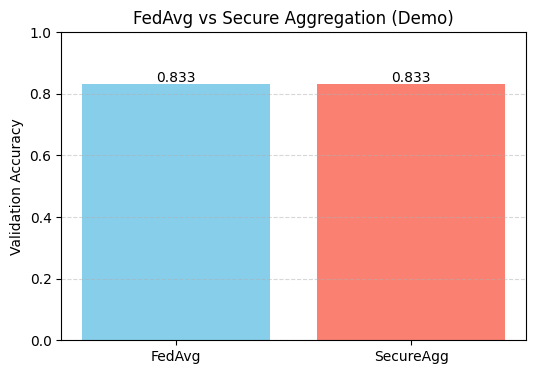

In [ ]:
#call secure_aggregate (clinet_states, client_ids) to generate an agg_state where zero-sum noise will delete
#upload agg_state in sec_model, valutate val_loader and print the validation accuracy
#take fed_final_acc = accs[-1] (the last accuracy of sparse FedAvg) and show in a bar chart that compare the 2 strategies

agg_state = secure_aggregate(client_states, client_ids)
print("🔐 secure_aggregate produced a state_dict aggregate.")

# Carico nello stesso modello finale e valuto
sec_model = deepcopy(model).to(device)
sec_model.load_state_dict(agg_state)
sec_model.eval()

sec_acc = evaluate_model(sec_model, val_loader, device)
print(f"📊 Demo SecureAgg Val Acc: {sec_acc:.4f}")

# 3) Confronto a barre con l’ultima fed_accs[-1]
fed_final_acc = accs[-1]
print(f"📊 FedAvg final Val Accuracy: {fed_final_acc:.4f}")

plt.figure(figsize=(6,4))
labels = ['FedAvg', 'SecureAgg']
scores = [fed_final_acc, sec_acc]
bars = plt.bar(labels, scores, color=['skyblue','salmon'])
plt.ylim(0,1)
plt.ylabel('Validation Accuracy')
plt.title('FedAvg vs Secure Aggregation (Demo)')
for bar, val in zip(bars, scores):
    plt.text(bar.get_x()+bar.get_width()/2, val+0.005, f"{val:.3f}", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

✅ Plot saved to /content/drive/MyDrive/fed_learning/plots/centralized_vs_sparse.png


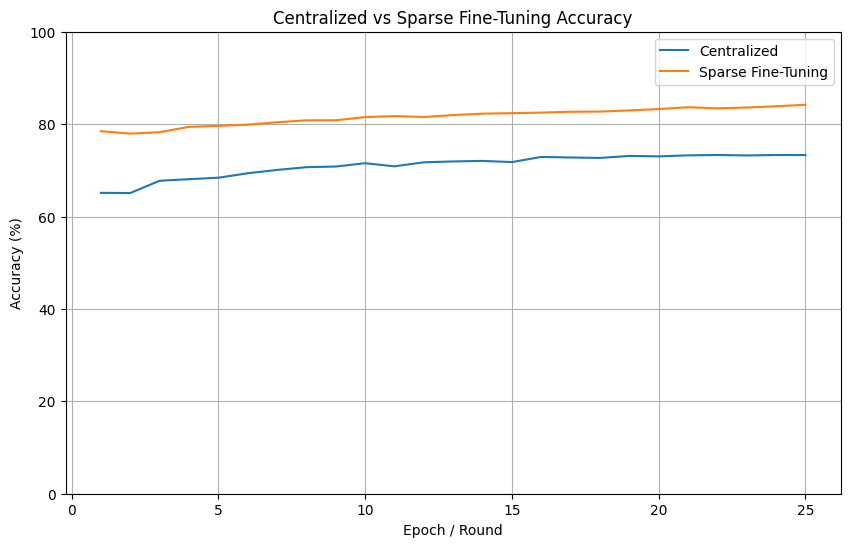

In [ ]:
#PLOTS

def plot_logs_percent(log_paths, labels, title="Validation Accuracy", ylabel="Accuracy (%)", save_path=None):
    plt.figure(figsize=(10, 6))

    for log_path, label in zip(log_paths, labels):
        if not os.path.exists(log_path):
            print(f"❌ Log file not found for {label}: {log_path}")
            continue

        rounds, accs = [], []
        with open(log_path, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                # Expect "Round X | Val Acc: Y.YYYY"
                if "| Val Acc:" in line:
                    left, right = line.split("| Val Acc:")
                    try:
                        r = int(left.replace("Round", "").strip())
                        v = float(right.strip())
                    except:
                        # fallback to plain float
                        continue
                else:
                    # maybe it's just a number per line
                    try:
                        r = len(rounds) + 1
                        v = float(line)
                    except:
                        continue

                # if v is a fraction ∈[0,1], scale to percent
                if 0 <= v <= 1:
                    v *= 100.0

                rounds.append(r)
                accs.append(v)

        if not rounds:
            print(f"⚠️ No valid entries in {log_path}")
            continue

        plt.plot(rounds, accs, label=label)

    plt.title(title)
    plt.xlabel("Epoch / Round")
    plt.ylabel(ylabel)
    plt.ylim(0, 100)
    plt.grid(True)
    plt.legend()

    if save_path:
        plt.savefig(save_path)
        print(f"✅ Plot saved to {save_path}")
    plt.show()


os.makedirs("/content/drive/MyDrive/fed_learning/plots/", exist_ok=True)

# usage:
plot_logs_percent(
    log_paths=[
        "/content/drive/MyDrive/fed_learning/centralized/log.txt",
        "/content/drive/MyDrive/fed_learning/sparse_finetune/log.txt"
    ],
    labels=["Centralized", "Sparse Fine-Tuning"],
    title="Centralized vs Sparse Fine-Tuning Accuracy",
    save_path="/content/drive/MyDrive/fed_learning/plots/centralized_vs_sparse.png"

)

✅ Plot saved to /content/drive/MyDrive/fed_learning/plots/federatedtraining_comparison.png


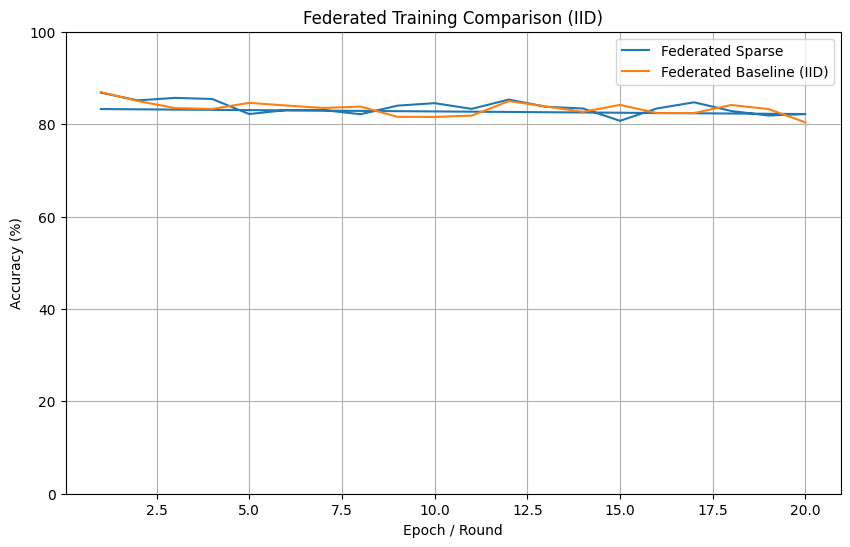

In [ ]:
# Assuming the logs are located at "<folder>/log.txt", we build full paths
plot_logs_percent(
    log_paths=[
        "/content/drive/MyDrive/fed_learning/fed_sparse_models/log.txt",
        "/content/drive/MyDrive/fed_learning/fed_baseline/iid/log.txt"
    ],
    labels=["Federated Sparse", "Federated Baseline (IID)"],
    title="Federated Training Comparison (IID)",
    save_path="/content/drive/MyDrive/fed_learning/plots/federatedtraining_comparison.png"

)

In [ ]:
def save_plot_logs(log_dirs, labels, save_path, title="Validation Accuracy", ylabel="Accuracy (%)"):
    plt.figure(figsize=(10, 6))
    for log_dir, label in zip(log_dirs, labels):
        log_path = os.path.join(log_dir, "logs", "log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                accs = [float(line.strip()) for line in f.readlines()]
                plt.plot(range(1, len(accs) + 1), accs, label=label)
    plt.title(title)
    plt.xlabel("Epoch / Round")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path)
    print(f"✅ Plot saved to {save_path}")


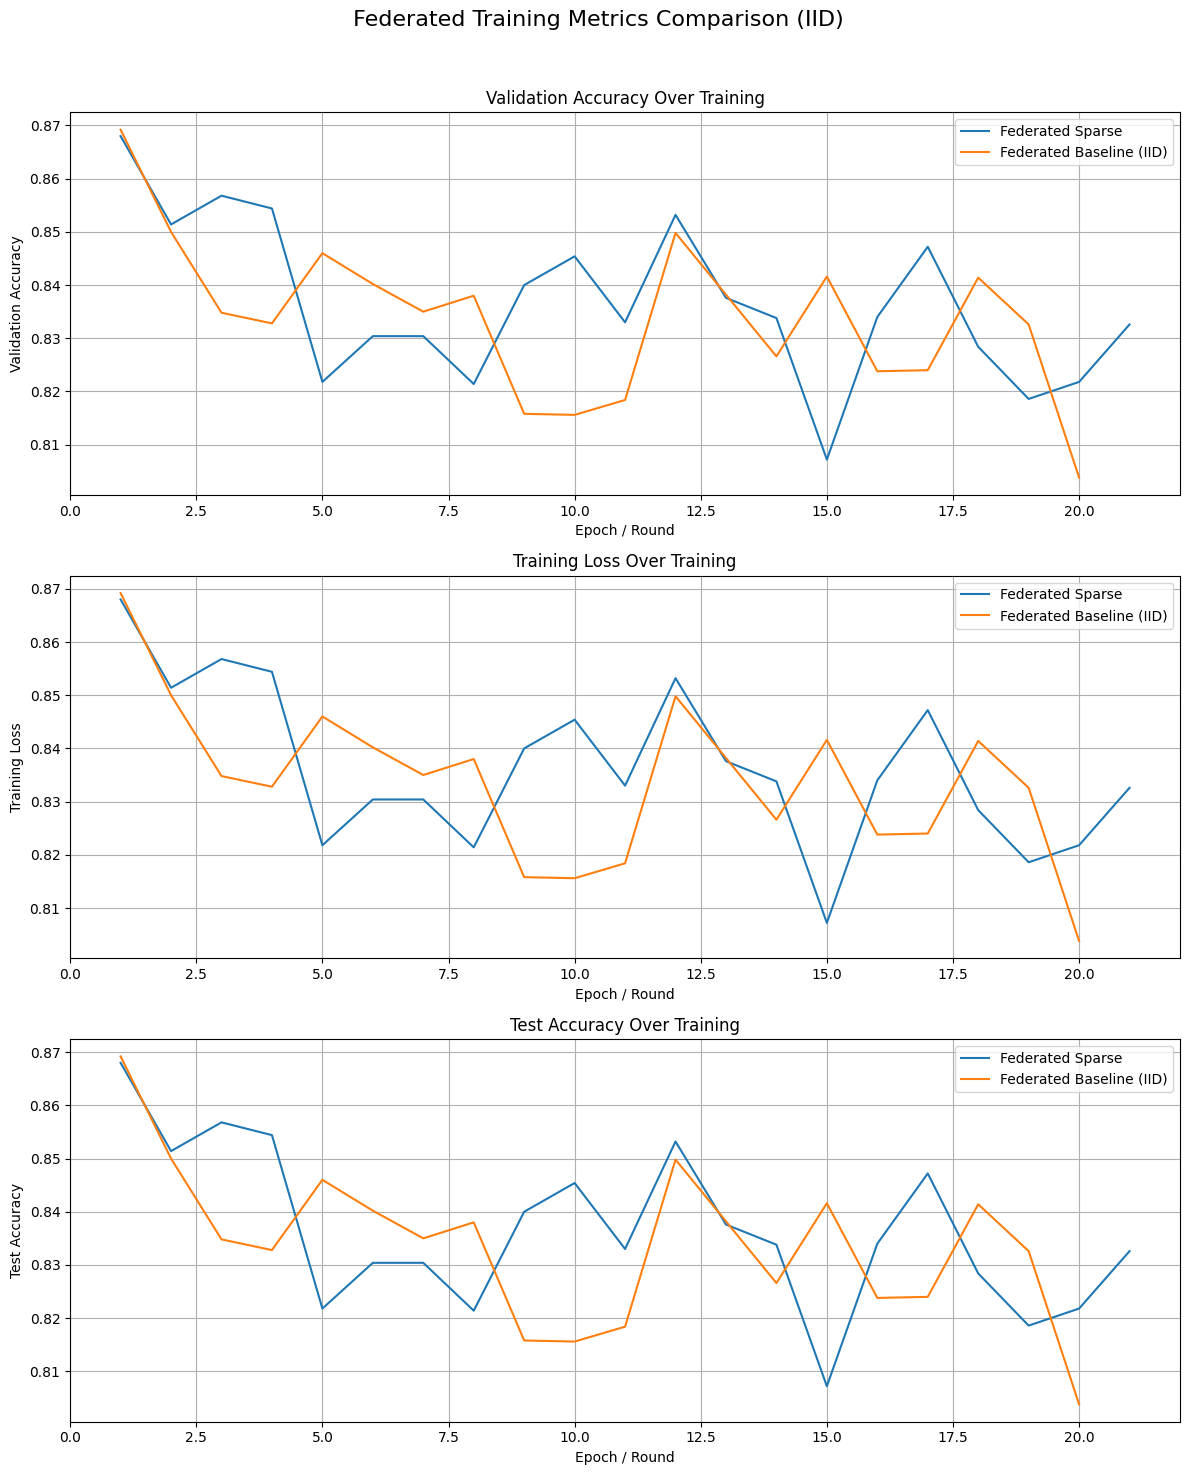

In [ ]:
import os
import matplotlib.pyplot as plt

def plot_metrics(metric_logs, labels, title="Training Metrics", save_path=None):
    """
    metric_logs: dict of {metric_name: list of log file paths}
    labels: list of experiment names (same length as each metric's log list)
    Example:
    metric_logs = {
        "Validation Accuracy": [path1, path2],
        "Training Loss": [path3, path4],
        "Test Accuracy": [path5, path6]
    }
    labels = ["Experiment 1", "Experiment 2"]
    """

    metrics = list(metric_logs.keys())
    n_metrics = len(metrics)

    fig, axs = plt.subplots(n_metrics, 1, figsize=(12, 5 * n_metrics))

    if n_metrics == 1:
        axs = [axs]  # make it iterable

    for i, metric in enumerate(metrics):
        ax = axs[i]
        log_paths = metric_logs[metric]

        for log_path, label in zip(log_paths, labels):
            if os.path.exists(log_path):
                with open(log_path, "r") as f:
                    values = []
                    for line in f.readlines():
                        try:
                            # Try to parse lines like "Round X | Val Acc: Y.YYYY"
                            parts = line.strip().split(" | ")
                            if len(parts) == 2:
                                # Extract value from format: "Val Acc: 0.6512"
                                val_part = parts[1]
                                value = float(val_part.split(": ")[1])
                                values.append(value)
                            else:
                                # fallback: just convert line to float
                                values.append(float(line.strip()))
                        except Exception as e:
                            continue

                    if values:
                        ax.plot(range(1, len(values) + 1), values, label=label)
                    else:
                        print(f"⚠️ No valid {metric} data found in {log_path}")
            else:
                print(f"❌ Log file not found for {label} - {metric}: {log_path}")

        ax.set_title(f"{metric} Over Training")
        ax.set_xlabel("Epoch / Round")
        ax.set_ylabel(metric)
        ax.grid(True)
        ax.legend()

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Example usage (replace paths with your actual log file paths)
plot_metrics(
    metric_logs={
        "Validation Accuracy": [
            "/content/drive/MyDrive/fed_learning/fed_sparse_models/log.txt",
            "/content/drive/MyDrive/fed_learning/fed_baseline/iid/log.txt"
        ],
        "Training Loss": [
            "/content/drive/MyDrive/fed_learning/fed_sparse_models/log.txt",
            "/content/drive/MyDrive/fed_learning/fed_baseline/iid/log.txt"
        ],
        "Test Accuracy": [
            "/content/drive/MyDrive/fed_learning/fed_sparse_models/log.txt",
            "/content/drive/MyDrive/fed_learning/fed_baseline/iid/log.txt"
        ]
    },
    labels=["Federated Sparse", "Federated Baseline (IID)"],
    title=" Federated Training Metrics Comparison (IID)",
    save_path="/content/drive/MyDrive/fed_learning/plots/fed_metric_comparison_iid.png"

)


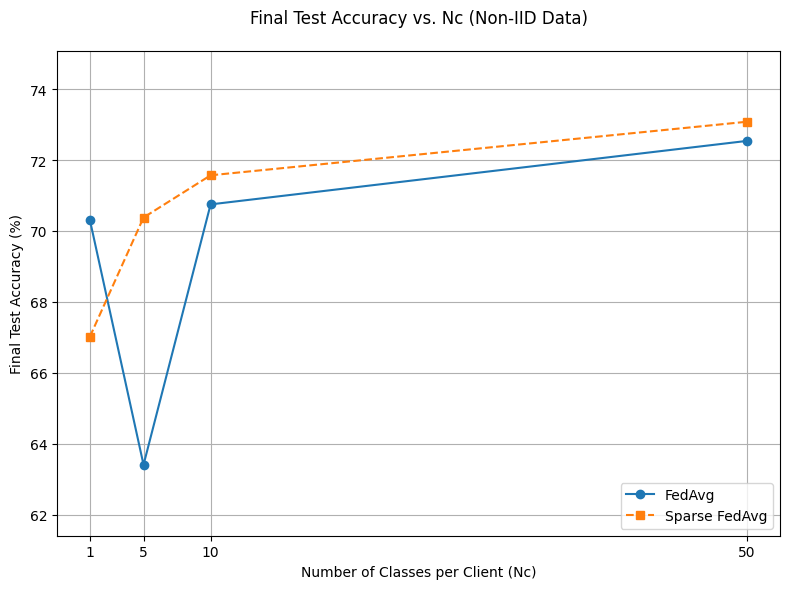

In [ ]:
import matplotlib.pyplot as plt

def plot_final_accuracy_noniid(nc_values, fedavg_accs, sparse_accs, title, save_path):
    plt.figure(figsize=(8, 6))

    # Line plot with markers
    plt.plot(nc_values, fedavg_accs, marker='o', linestyle='-', label='FedAvg', color='tab:blue')
    plt.plot(nc_values, sparse_accs, marker='s', linestyle='--', label='Sparse FedAvg', color='tab:orange')

    plt.xlabel("Number of Classes per Client (Nc)")
    plt.ylabel("Final Test Accuracy (%)")
    plt.title(title, pad=20)
    plt.xticks(nc_values)
    plt.ylim(min(fedavg_accs + sparse_accs) - 2, max(fedavg_accs + sparse_accs) + 2)  # dynamic range with buffer
    plt.grid(True)
    plt.legend(loc='lower right')

    # Ensure layout doesn't cut title or labels
    plt.tight_layout()

    plt.savefig(save_path, bbox_inches='tight')  # ensures nothing gets cut off
    plt.show()

# Fixed accuracy values and call
plot_final_accuracy_noniid(
    nc_values=[1, 5, 10, 50],
    fedavg_accs=[70.31, 63.41, 70.75, 72.54],   # Fixed typo 7075 → 70.75
    sparse_accs=[67.02, 70.38, 71.57, 73.08],
    title="Final Test Accuracy vs. Nc (Non-IID Data)",
    save_path="/content/drive/MyDrive/fed_learning/plots/noniid_final_accuracy_comparison.png"
)


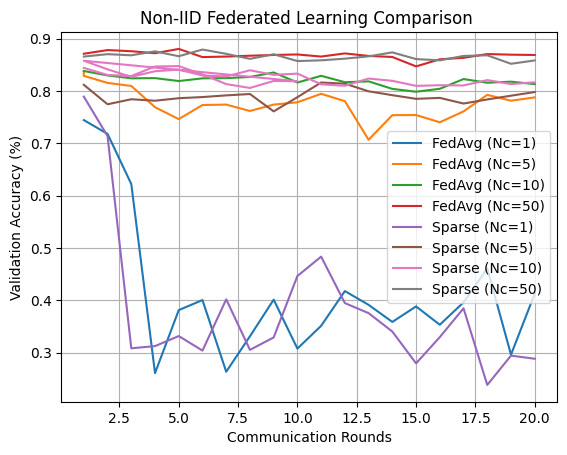

In [ ]:
plot_logs_percent(
    log_paths=[
        "/content/drive/MyDrive/fed_learning/fed_baseline/noniid_nc1/log.txt",
        "/content/drive/MyDrive/fed_learning/fed_baseline/noniid_nc5/log.txt",
        "/content/drive/MyDrive/fed_learning/fed_baseline/noniid_nc10/log.txt",
        "/content/drive/MyDrive/fed_learning/fed_baseline/noniid_nc50/log.txt",
        "/content/drive/MyDrive/fed_learning/fed_sparse_models/sparse_noniid_nc1/log.txt",
        "/content/drive/MyDrive/fed_learning/fed_sparse_models/sparse_noniid_nc5/log.txt",
        "/content/drive/MyDrive/fed_learning/fed_sparse_models/sparse_noniid_nc10/log.txt",
        "/content/drive/MyDrive/fed_learning/fed_sparse_models/sparse_noniid_nc50/log.txt"

    ],
    labels=[
        "FedAvg (Nc=1)", "FedAvg (Nc=5)", "FedAvg (Nc=10)", "FedAvg (Nc=50)",
        "Sparse (Nc=1)", "Sparse (Nc=5)", "Sparse (Nc=10)", "Sparse (Nc=50)"
    ],
    title="Non-IID Federated Learning Comparison ",
    save_path="/content/drive/MyDrive/fed_learning/plots/federatedtraining_noniid_comparison.png"
)